In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Is CUDA available: True
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.6983, node: C(C)N(Cc1ccncc1)C(=O)CCCc1ccccc1
<best reward updated> order: 4, time: 0.03, reward: 0.7040, node: OCCN(Cc1ccccc1)Cc1cccc(Cl)c1
<best reward updated> order: 34, time: 0.63, reward: 0.7478, node: N/C(C(=O)c1ccc(Cl)cc1)(N(Cc1ccccc1)c1ccccc1)c1ccccc1
<best reward updated> order: 77, time: 1.43, reward: 0.7763, node: OCc1cn(Cc2ccc(Br)o2)cn1
generated: 100, time: 1.91, average over 100: -0.1244
<best reward updated> order: 111, time: 2.07, reward: 0.7945, node: N[C@H](COCC(F)(F)F)c1ccc(Br)s1
<best reward updated> order: 134, time: 2.47, reward: 0.9010, node: N[C@H](N(C=CC1CC1)C1CC1)C(F)(F)F
generated: 200, time: 3.52, average over 100: -0.0557
<best reward updated> order: 212, time: 3.64, reward: 0.9199, node: C/C(CC(C)C)=C/C1CC1
<best reward updated> order: 257, time: 4.41, reward: 0.9456, node: C[C@H]([C@@H](C)O)[C@H](C)CC(=O)[O-]
generated: 300, time: 5.23, average over 100: 0

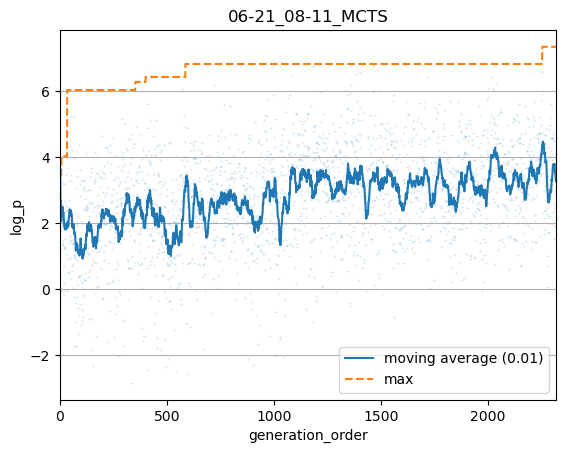

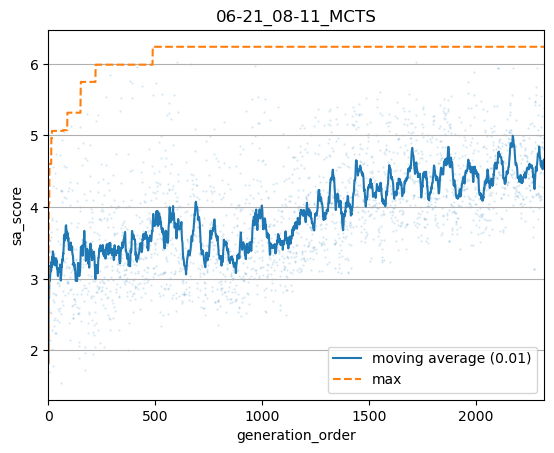

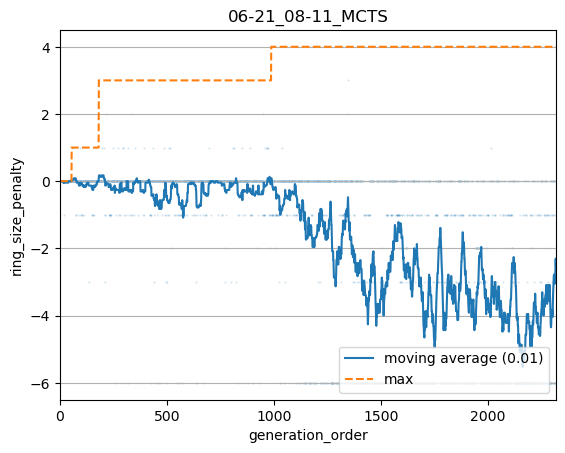

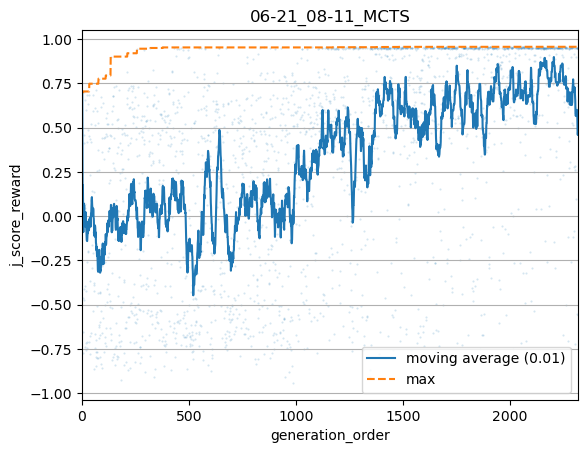

number of generated nodes: 2319
valid rate: 0.6575095699166854
unique rate: 0.8646701193424904
node_per_sec: 77.25805944184975


In [13]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
generator, conf = read_yaml(c3)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)